In [1]:
import time
import os
import joblib
import warnings
# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

In [2]:
filepath = 'bitcoin.csv'
data = pd.read_csv(os.path.join('./data', filepath))
data = data.sort_values('Date')
price = data[['Close']]
scaler = MinMaxScaler(feature_range=(-1, 1))
price.loc[:, 'Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))

In [3]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    lookback+=1
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train[:,:,0], y_train, x_test[:,:,0], y_test]

In [4]:
def get_train_test_data(data, sequence: int=20, verbose=True):
    x_train, y_train, x_test, y_test = split_data(data, sequence)
    if verbose:
        print('x_train.shape = ',x_train.shape)
        print('y_train.shape = ',y_train.shape)
        print('x_test.shape = ',x_test.shape)
        print('y_test.shape = ',y_test.shape)
    return x_train, y_train, x_test, y_test

## SVR

In [5]:
sequence_len = [1, 2, 5, 10, 15, 20, 25]
svr_grid_search = []
for i in range(len(sequence_len)):
    svr_grid_search.append(joblib.load('models/svr/gs_'+str(sequence_len[i])+'seq.pkl'))

In [6]:
params = ['C', 'coef0', 'degree', 'epsilon', 'kernel']
search_params = ['_'.join(['param',param]) for param in params]

In [7]:
for i in range(len(sequence_len)):
    print(svr_grid_search[i].best_score_)

-111.68169774253029
-111.86781200731471
-22.866397301346975
-2.9668467913959686
-81.30228463037835
-65.84761493497095
-12.226666972879704


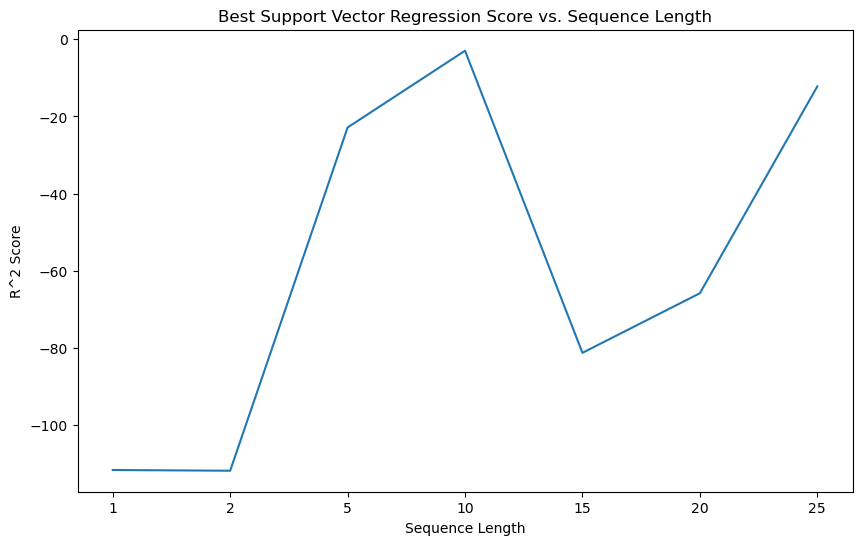

In [8]:
best_acc = []
for i in range(len(sequence_len)):
    best_acc.append(svr_grid_search[i].best_score_)

ax = plt.figure(figsize=(10,6))
plt.plot(best_acc)
plt.ylabel('R^2 Score')
plt.xlabel('Sequence Length')
plt.xticks(range(len(sequence_len)), [str(s) for s in sequence_len]);
plt.title('Best Support Vector Regression Score vs. Sequence Length')
plt.savefig('figures/svr/best_score_vs_len.png')

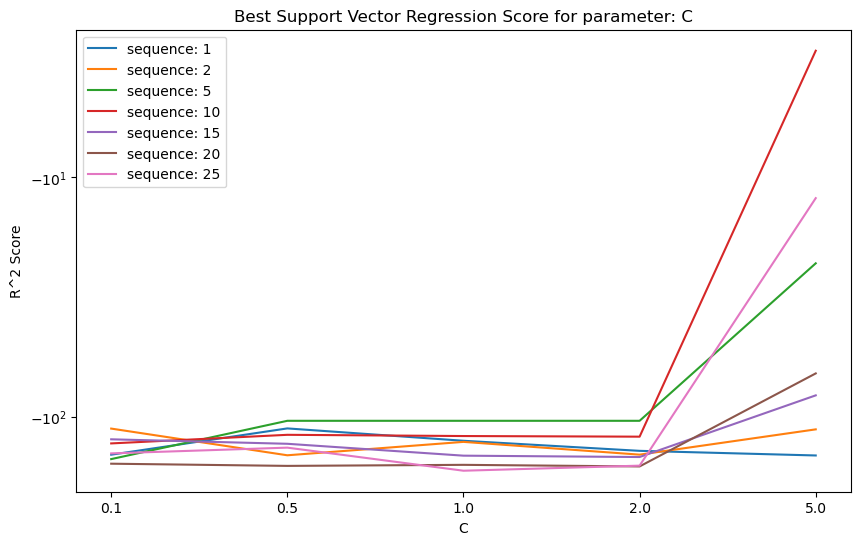

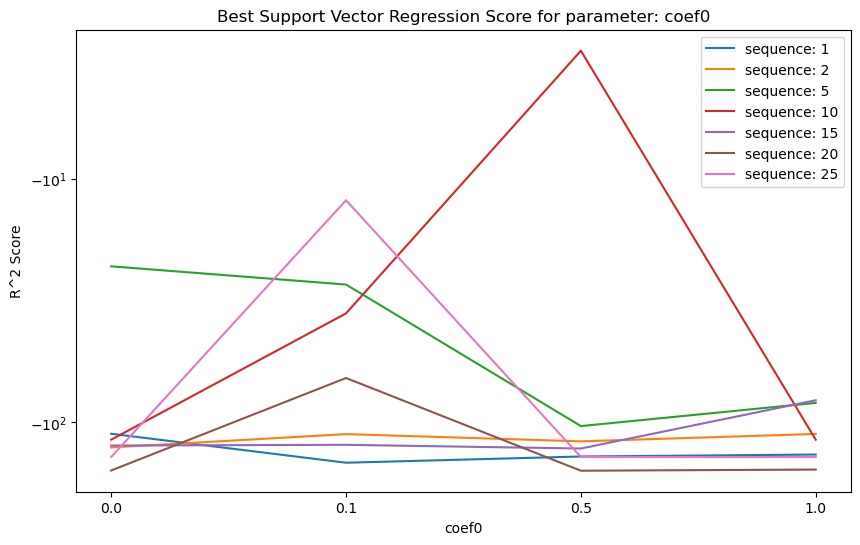

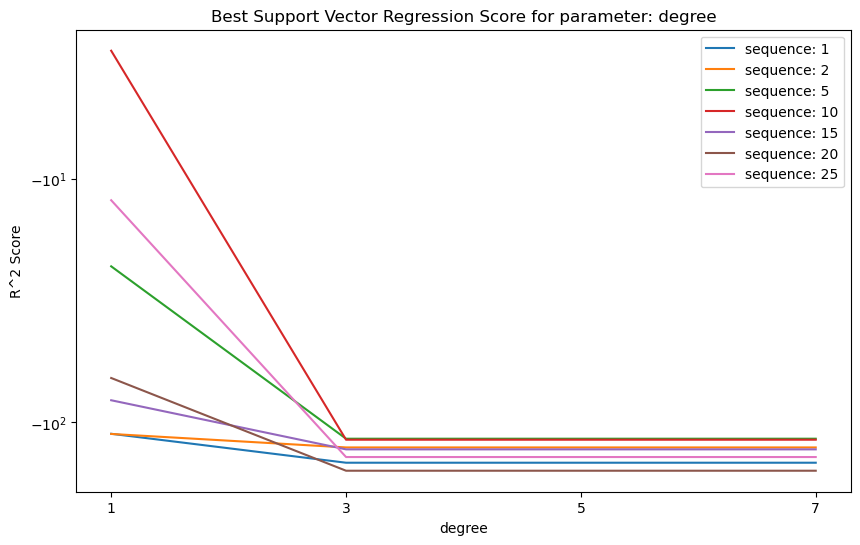

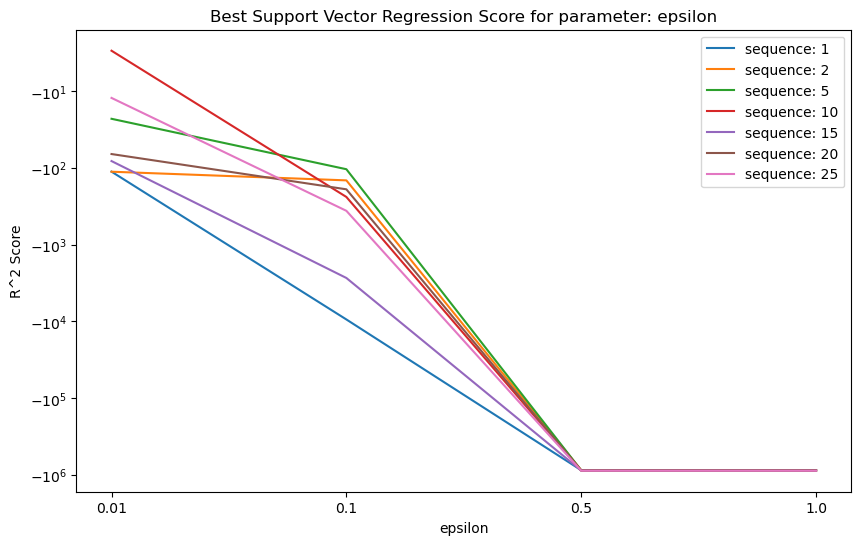

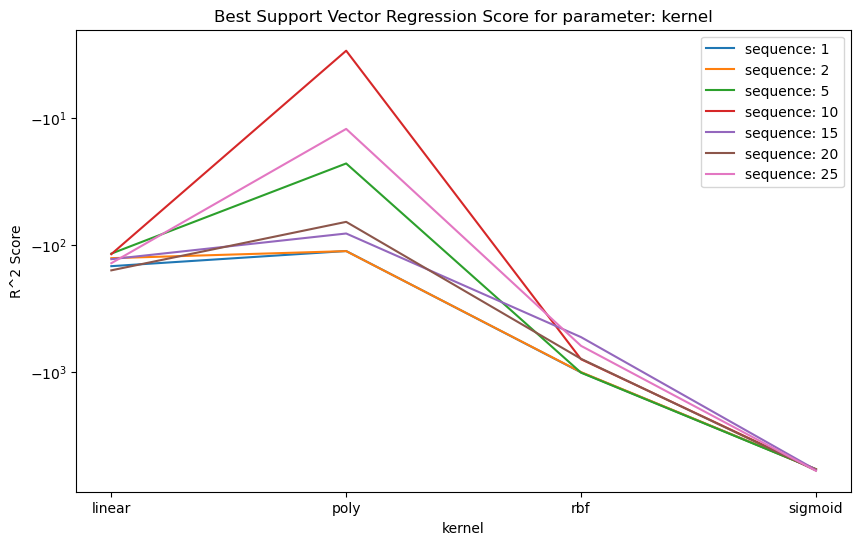

In [9]:
for j in range(len(search_params)):
    param = search_params[j]
    fig = plt.figure(figsize=(10,6))
    index = pd.DataFrame(svr_grid_search[0].cv_results_).groupby(param)['mean_test_score'].max().index
    for i in range(len(sequence_len)):
        temp = pd.DataFrame(svr_grid_search[i].cv_results_)
        vals = temp.groupby(param)['mean_test_score'].max()
        plt.plot(vals.values, label='sequence: '+str(sequence_len[i]))
    plt.legend()
    plt.title('Best Support Vector Regression Score for parameter: '+params[j])
    plt.yscale('symlog')
    plt.xlabel(params[j])
    plt.ylabel('R^2 Score')
    plt.xticks(list(range(len(index))), index)
    plt.savefig('figures/svr/best_score_vs_'+param+'.png')
    plt.show()

### Best SVR's predictions

In [15]:
best_score = -1*np.inf
best_svr = None
best_len = 0
for i in range(len(svr_grid_search)):
    seq_len = sequence_len[i]
    model = svr_grid_search[i]
    score = model.best_score_
    print('Best Model for Sequence Length:', seq_len)
    print('                         Score:', score)
    if score > best_score:
        best_score = score
        best_svr = model
        best_len = seq_len

Best Model for Sequence Length: 1
                         Score: -111.68169774253029
Best Model for Sequence Length: 2
                         Score: -111.86781200731471
Best Model for Sequence Length: 5
                         Score: -22.866397301346975
Best Model for Sequence Length: 10
                         Score: -2.9668467913959686
Best Model for Sequence Length: 15
                         Score: -81.30228463037835
Best Model for Sequence Length: 20
                         Score: -65.84761493497095
Best Model for Sequence Length: 25
                         Score: -12.226666972879704


In [16]:
print('     Best Score:', best_score)
print('Sequence Length:', best_len)

     Best Score: -2.9668467913959686
Sequence Length: 10


In [17]:
x_train,y_train,x_test,y_test = get_train_test_data(price, best_len)

x_train.shape =  (3527, 10)
y_train.shape =  (3527, 1)
x_test.shape =  (882, 10)
y_test.shape =  (882, 1)


In [19]:
y_test_pred = best_svr.predict(x_test)

In [32]:
y_test.shape

(882, 1)

In [34]:
y_test_pred.reshape(-1,1).shape

(882, 1)

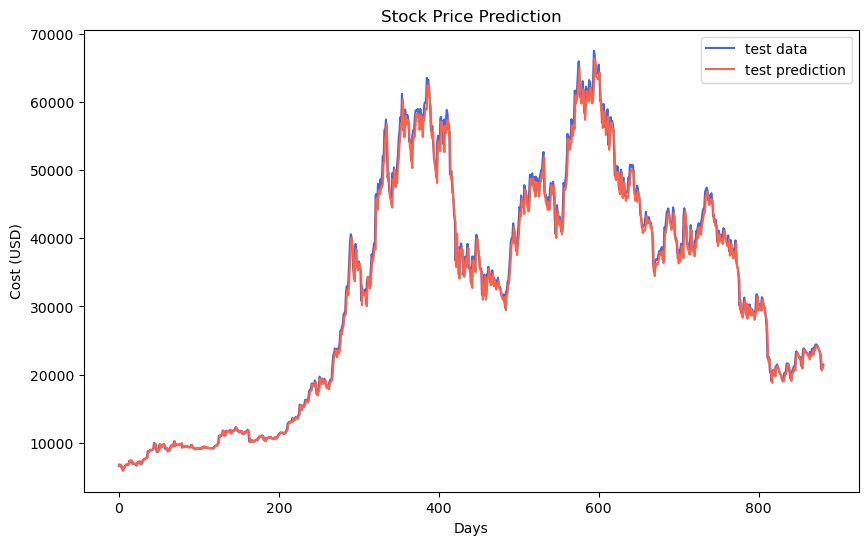

In [38]:
fig = plt.figure(figsize=(10,6))
plt.plot(scaler.inverse_transform(y_test), color='royalblue', label='test data')
plt.plot(scaler.inverse_transform(y_test_pred.reshape(-1,1)), color='tomato', label='test prediction')
plt.title('Stock Price Prediction')
plt.ylabel('Cost (USD)')
plt.xlabel('Days')
plt.legend()